
### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2020 Semester 1

## Assignment 1: Naive Bayes Classifiers

###### Submission deadline: 7 pm, Monday 20 Apr 2020

**Student Name(s):**    Patrick Randell, Rohan Hitchcock

**Student ID(s):**     836026, 836598

In [1]:
import numpy as np
import pandas as pd
import json
import os
from collections import namedtuple
from math import log
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import KBinsDiscretizer as KBD



In [33]:
RANDOM_SEED = 2
NUM_PARTITIONS = 10
F_SCORE_BETA = 1
NUM_DISCRETE = 5

# Change these filepaths to the correct ones for your local instance
MUSHROOM = '../../datasets/mushroom.data'
ADULT = '../../datasets/adult.data'
NURSERY = '../../datasets/nursery.data'
WDBC = '../../datasets/wdbc.data'
WINE = '../../datasets/wine.data'
BANK = '../../datasets/bank.data'
LYMPHOGRAPHY = '../../datasets/lymphography.data'


###### All function definitions follow. No code is run until after all funciton definitions.

In [8]:
def preprocess(filepath, header=None, config_file="config.json"):

    #load configuration settings from file
    with open(config_file) as fp:
        config = json.load(fp)

    #extract the name of the dataset from the filepath
    pth, fname = os.path.split(filepath)    #pylint:disable=unused-variable
    fname, ext = os.path.splitext(fname)    #pylint:disable=unused-variable

    if fname not in config:
        raise NotImplementedError(f"The \'{fname}\' dataset is not supported.")
    
    data_config = config[fname]
    print(fname)
    print(data_config)
    print()

    df = pd.read_csv(
        filepath, 
        header=header, 
        names=range(data_config['columns']),
        na_values=data_config['missing_values']
    )
    
    df = df.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)
    
    return df, data_config

In [4]:
""" Convenient way to store the data for a learned Naive Bayes model. 

    Fields:
        discrete:     discrete probability data. A triple-nested dictionary
                      such that discrete[da][c][x] = P(x|c) where x is a 
                      value of a discrete attribute da.
        numeric:      numeric probability data. A dictionary (keyed by attribute 
                      name) of tuples (mu, sigma) where each is an array of the 
                      same length as class_vals storing the mean and standard 
                      deviation of this attribute for each class value.
        class_vals:   an array of possible values of the class to predict
        class_priors: an array the same length of class_vals such that the ith
                      element is the probability of class_vals[i]
"""
NBModel = namedtuple("NBModel", ['discrete', 'numeric',
                                 'class_vals', 'class_priors'])

def discrete_probabilities(obs, vals):
    """ Estimates the probability of observing each value of a discrete 
        phenomena, based on a series of observations.

        Args:
            obs: a numpy array of observations where each element is contained 
            in vals
            vals: an iterable of possibly observable values

        Returns:
            A numpy array a where a[i] is the probability of observing vals[i]
    """
    return np.array([np.count_nonzero((obs == v)) / len(obs) for v in vals])


def train_discrete_standard(df, class_attr, class_vals, d_attr, eps=0):
    """ For training Naive Bayes on a discrete attribute, with no / simple 
        smoothing.

        For each class value computes the conditional probability of observing 
        each attribute value given that class value. 

        Args:
            df: a pd.DataFrame
            class_attr: the column in df of the class to predict
            class_vals: the possible values of class_attr
            d_attr: the column in df of the discrete attribute
            eps: (optional) a value to replace any zero probabilities with.

        Returns:
            A dictionary, keyed by class values, of dictonaries storing the 
            conditional probability of observing each attribute value
    """

    attr_vals = df[d_attr].unique()

    params = dict()
    for cv in class_vals:

        params[cv] = dict()
        cv_obs = df[df[class_attr] == cv]
        for av in attr_vals:
            num_av_obs = np.count_nonzero((cv_obs[d_attr] == av).to_numpy())

            pval = num_av_obs / cv_obs.shape[0]

            params[cv][av] = pval if pval != 0 else eps

    return params


def train_gaussian(df, class_attr, class_values, num_attr):
    """ For training Naive Bayes on a numeric attribute.
    
        Calculates the mean and standard deviation of a numeric attribute for 
        each class. 

        Args:
            df: A pd.DataFrame 
            class_attr: the column in df of the class we are predicting
            class_values: an iterable of each possible value of class_attr
            num_attr: a numeric attribute in df

        Returns:
            A dictionary (keyed by the class values) of tuples (mean, std)
    """

    means = np.empty(len(class_values))
    stdevs = np.empty(len(class_values))
    for i, cv in enumerate(class_values):
        # A Series which is True wherever cv was observed and false otherwise
        cv_obs = df[class_attr] == cv

        # TODO: write our own functions?
        # by default Series.mean and Series.std will skip missing vals
        means[i] = df[num_attr][cv_obs].mean()
        stdevs[i] = df[num_attr][cv_obs].std()

    return means, stdevs


def train(df, discrete_attrs, numeric_attrs, class_name,
          train_discrete=train_discrete_standard, train_numeric=train_gaussian):
    """ Produce a Naive Bayes model for a given dataset.
    
        Args:
            df: a pd.DataFrame of training data
            discrete_attrs: a list of discrete attribute names of df
            numeric_attrs: a list of numeric attribute names of df
            class_name: the name in df of the class to predict
            train_discrete: a callable 
                train_discrete(df, class_name, class_vals, attr) which calculates
                the conditional probabilities of a discrete attribute attr
            train_numeric: a callable 
                train_numeric(df, class_name, class_vals, attr) which calculates
                the means and standard deviations of a numeric attribute attr
        
        Returns:
            A NBModel object
    """
    class_vals = df[class_name].unique()

    discrete = dict()
    for da in discrete_attrs:
        discrete[da] = train_discrete(df, class_name, class_vals, da)

    numeric = dict()
    for na in numeric_attrs:
        numeric[na] = train_numeric(df, class_name, class_vals, na)

    class_priors = discrete_probabilities(df[class_name].to_numpy(), class_vals)

    return NBModel(discrete, numeric, class_vals, class_priors)


In [5]:
def guassian_pdf(x, mu, sigma):
    """Gaussian probability density function. Assumes a gaussian distribution for numeric attributes and calculates 
        the probabilities based on the density function
        Args:
            x: attribute value
            mu: Attribute mean
            sigma: Attribute Standard Deviation
        Returns:
            Likely hood of observing x
    """
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (((x - mu) / sigma) ** 2))

def loglim(x):
    """ Returns log(x) for positive x and -float("inf") otherwise"""
    return log(x) if x > 0 else -float("inf")

def predict(df, nbm):
    """ Predict class labels using a Naive Bayes model.

        Args:
            df: a pd.DataFrame storing training instances.
            nbm: a NBModel object trained to predict on instances in df
        Returns:
            A pd.Series of class labels, with index equal to df.index
    """

    # numeric and discrete attributes
    n_attrs = list(nbm.numeric.keys())
    d_attrs = list(nbm.discrete.keys())

    predictions = pd.Series(
        np.empty(len(df), 
        dtype=nbm.class_vals.dtype), 
        index=df.index
    )

    for idx, row in df.iterrows():

        class_likelyhoods = np.empty(len(nbm.class_vals))
        for i, cv in enumerate(nbm.class_vals):

            cl = loglim(nbm.class_priors[i])

            if d_attrs:
                for a, x in zip(d_attrs, row[d_attrs]):

                    # TODO: this is not correct, need to change training?
                    if pd.notna(x) and x in nbm.discrete[a][cv]:
                        cl += loglim(nbm.discrete[a][cv][x])

            if n_attrs:
                for a, x in zip(n_attrs, row[n_attrs]):
                    if pd.notna(x):
                        # means and standard deviations for this numeric attribute
                        means, stdevs = nbm.numeric[a]
                        cl += loglim(guassian_pdf(x, means[i], stdevs[i]))

            class_likelyhoods[i] = cl

        predictions[idx] = nbm.class_vals[np.argmax(class_likelyhoods)]
    return predictions


In [6]:
# This function should evaluate the prediction performance by comparing your model’s class outputs to ground
# truth labels


def evaluate(truth_labels, predictions, f_score_beta=F_SCORE_BETA):
    """ Evaluates a prediction compared to the ground truth labels according to 
        a number of different metrics."""
    assert (len(truth_labels) == len(predictions))
    a = accuracy(truth_labels, predictions)
    cm = confusion_matrix(truth_labels, predictions)
    p = precision(cm)
    r = recall(cm)
    f = f_score(p, r, f_score_beta)
    return a, p, r, f

def accuracy(class_col, ybar):
    results = np.array(class_col) == ybar
    return np.count_nonzero(results == True) / len(ybar)

def precision(cm):
    """Precision of each class, returned as an average weighted by the number of
    instances in each class"""
    fp = np.sum(cm, axis=0)
    precisions = np.diag(cm) / np.where(fp == 0, 1, fp)
    weights = np.sum(cm, axis=1) / cm.sum()
    return np.sum(precisions * weights)

def recall(cm):
    """Recall of each class, returned as an average weighted by the number of
    instances in each class"""
    fp = np.sum(cm, axis=1)
    recalls = np.diag(cm) / np.where(fp == 0, 1, fp)
    weights = np.sum(cm, axis=1) / cm.sum()
    return np.sum(recalls * weights)

def f_score(p, r, beta):

    denom = ((beta * beta * p) + r)

    if denom == 0:
        return 0
    else:
        return ((1 + beta * beta) * p * r) / denom
    

###### Basic run of the model using Lymphography. All Datasets loaded in here.

In [9]:
# Load in Datasets
adult, adult_cnfg = preprocess(ADULT)
bank, bank_cnfg = preprocess(BANK)
wine, wine_cnfg = preprocess(WINE)
wdbc, wdbc_cnfg = preprocess(WDBC)
nurs, nurs_cnfg = preprocess(NURSERY)
mush, mush_cnfg = preprocess(MUSHROOM)
lymph, lymph_cnfg = preprocess(LYMPHOGRAPHY)

# Basic run with Lymphography
df = lymph
df_config = lymph_cnfg
#training on all data for now, we use cross validation later on
model = train(df, df_config['discrete'], df_config['numeric'], df_config['class_col'])

#predicting on all data for now, we use cross validation later on
predictions = predict(df, model)
acc, prec, rec, fsc = evaluate(df[df_config['class_col']], predictions)

print(f"{LYMPHOGRAPHY}")
print(f"Accuracy: {acc}\nPrecision: {prec}\nRecall: {rec}\nF-Score (beta = {F_SCORE_BETA}): {fsc}")

adult
{'instances': 32561, 'columns': 15, 'class_col': 14, 'missing_values': ['?'], 'discrete': [1, 3, 4, 5, 6, 7, 8, 9, 13], 'numeric': [0, 2, 10, 11, 12]}

bank
{'instances': 45211, 'columns': 15, 'class_col': 14, 'missing_values': [], 'discrete': [1, 2, 3, 4, 6, 7, 8, 13], 'numeric': [0, 5, 9, 10, 11, 12]}

wine
{'instances': 178, 'columns': 14, 'class_col': 0, 'missing_values': [], 'discrete': [], 'numeric': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}

wdbc
{'instances': 569, 'columns': 32, 'class_col': 1, 'missing_values': [], 'discrete': [], 'numeric': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]}

nursery
{'instances': 12960, 'class_col': 8, 'missing_values': [], 'columns': 9, 'discrete': [0, 1, 2, 3, 4, 5, 6, 7], 'numeric': []}

mushroom
{'instances': 8124, 'columns': 23, 'class_col': 0, 'missing_values': ['?'], 'discrete': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'numer

## Questions 


If you are in a group of 1, you will respond to question (1), and **one** other of your choosing (two responses in total).

If you are in a group of 2, you will respond to question (1) and question (2), and **two** others of your choosing (four responses in total). 

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions in respond to the question, but your formal answer should be added to a separate file.

### Q4
Evaluating the model on the same data that we use to train the model is considered to be a major mistake in Machine Learning. 
Implement a hold–out or cross–validation evaluation strategy (you should implement this yourself and do not simply call 
existing implementations from `scikit-learn`). How does your estimate of effectiveness change, compared to testing on 
the training data? Explain why. (The result might surprise you!)

###### NOTE: We have answered Q4 before other questions so that cross-validation can be used for subsequent questions!

In [34]:
def cross_validation_splits(df, k, seed=0):

    #set seed for reproducibility
    np.random.seed(seed)

    indicies = df.index.to_numpy(copy=True)
    np.random.shuffle(indicies)

    partitions = np.array_split(indicies, k)
    for i in range(k):

        test = partitions[i]
        train = np.concatenate(partitions[:i] + partitions[i + 1:])

        yield df.loc[train], df.loc[test]
        
def cross_validation_runner(df, cnfg, k, train_discrete=train_discrete_standard):
    results = {"accuracy":0, "precision":0, "recall":0, "f-score":0}
    for train_set, test_set in cross_validation_splits(df, k):
        model = train(train_set, cnfg["discrete"], cnfg["numeric"], cnfg["class_col"], train_discrete=train_discrete)
        predictions = predict(test_set, model)
        truth = test_set[cnfg["class_col"]]
        a, p, r, f = evaluate(truth, predictions)
        results["accuracy"] += a
        results["precision"] += p
        results["recall"] += r
        results["f-score"] += f
    for key in results.keys():
        results[key]=results[key]/k
    return results

In [35]:
#Answering Question with Bank dataset. 

#NOTE: This cell will take a while to run.

#Cross validation results
bank_r = cross_validation_runner(bank, bank_cnfg, NUM_PARTITIONS)

#Testing on Train set, no cross-validation
model = train(bank, bank_cnfg["discrete"], bank_cnfg["numeric"], bank_cnfg["class_col"], train_discrete=train_discrete_standard)
predictions = predict(bank, model)
truth = bank[bank_cnfg["class_col"]]
a, p, r, f = evaluate(truth, predictions)

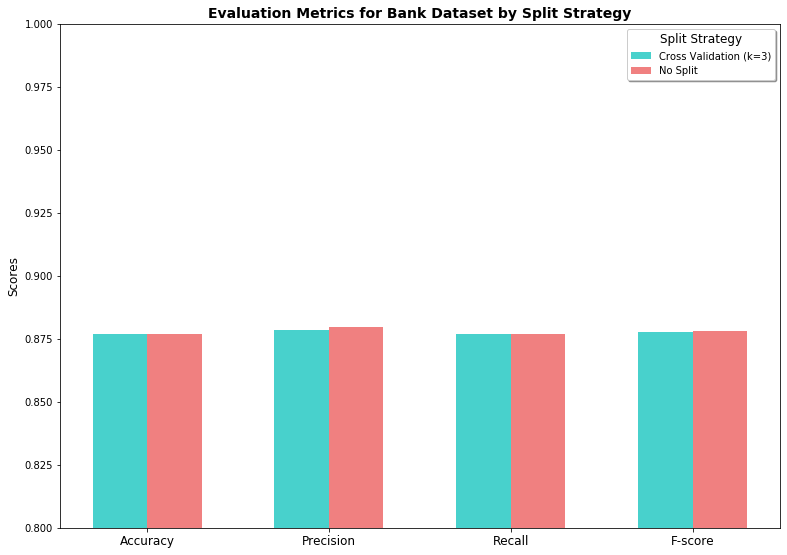

In [36]:
#Creating graph from results
cross_v = np.array((bank_r["accuracy"], bank_r["precision"], bank_r["recall"], bank_r["f-score"]))
test_on_train = np.array((a, p, r, f))

plt.rcParams['figure.figsize'] = [10, 7]
X = np.arange(4)
ind = X + 0.15
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim(0.8,1)
ax.bar(X + 0.00, cross_v, color = 'mediumturquoise', width = 0.3)
ax.bar(X + 0.3, test_on_train, color = 'lightcoral', width = 0.3)

plt.ylabel('Scores',size=12)
plt.title('Evaluation Metrics for Bank Dataset by Split Strategy', weight='bold',size=14)
plt.xticks(ind, ('Accuracy', 
                 'Precision',
                 'Recall',
                 'F-score'), size=12)
plt.legend(('Cross Validation (k='+str(NUM_PARTITIONS)+')','No Split'),shadow=True,title="Split Strategy",title_fontsize=12)

plt.show()

### Q1
Try discretising the numeric attributes in these datasets and treating them as discrete variables in the na¨ıve 
Bayes classifier. You can use a discretisation method of your choice and group the numeric values into any number 
of levels (but around 3 to 5 levels would probably be a good starting point). Does discretizing the variables improve 
classification performance, compared to the Gaussian na¨ıve Bayes approach? Why or why not?

In [14]:
def discretise_equal_width(numeric_series, nbins):
    """ Discretises a numeric data series accoding to equal-width discretisation
        
        Assumes no missing values.

        Args:
            numeric_series: a pd.Series containing numeric data
            nbins: the number of discrete classes for the data
            
        Returns:
            A pd.Series with nbins unique values.
    """

    est = KBD(n_bins=nbins, encode='ordinal', strategy='uniform')
    est.fit(numeric_series)
    return pd.DataFrame(est.transform(numeric_series), dtype='int64', columns=numeric_series.columns)


def discretise_k_means(numeric_series, k):
    """ Discretises a numeric data series according to k-means 

        Assumes no missing values.

        Args:
            numeric_series: a pd.Series containing numeric data
            k: the number of discrete categories
            repeates: the number of repeats of k-means
        
        Returns:
            A pd.Series with k unique values of the same index as numeric_series
    """

    est = KBD(n_bins=k, encode='ordinal', strategy='kmeans')
    est.fit(numeric_series)
    return pd.DataFrame(est.transform(numeric_series), dtype='int64', columns=numeric_series.columns)

def discretise_runner(df, cnfg, num_bins, strategy=discretise_k_means):
    """ Runner code that discretises all numeric attributes of a dataset
        and return the results after training and testing via cross-validation"""
    disc_df = df[cnfg["discrete"]].join(df[cnfg["class_col"]])
    discretized = strategy(df[cnfg["numeric"]], num_bins)
    disc_df = disc_df.join(discretized)
    disc_df = disc_df[sorted(list(disc_df.columns.values))]
    
    disc_cnfg = cnfg.copy()
    
    disc_cnfg["discrete"] = cnfg["discrete"] + cnfg["numeric"]
    disc_cnfg["numeric"] = []
    
    return cross_validation_runner(disc_df, disc_cnfg, NUM_PARTITIONS)


###### Numeric Datasets used are Adult, Bank, Wine and WDBC

In [15]:
#NOTE: This cell will take a while to run.

#Kmeans
adult_r_kmeans = discretise_runner(adult, adult_cnfg, NUM_DISCRETE)
bank_r_kmeans = discretise_runner(bank, bank_cnfg, NUM_DISCRETE)
wine_r_kmeans = discretise_runner(wine, wine_cnfg, NUM_DISCRETE)
wdbc_r_kmeans = discretise_runner(wdbc, wdbc_cnfg, NUM_DISCRETE)

#Equal Width
adult_r_eqw = discretise_runner(adult, adult_cnfg, NUM_DISCRETE, strategy=discretise_equal_width)
bank_r_eqw = discretise_runner(bank, bank_cnfg, NUM_DISCRETE, strategy=discretise_equal_width)
wine_r_eqw = discretise_runner(wine, wine_cnfg, NUM_DISCRETE, strategy=discretise_equal_width)
wdbc_r_eqw = discretise_runner(wdbc, wdbc_cnfg, NUM_DISCRETE, strategy=discretise_equal_width)

#GaussianNB (Cross-Val) (Bank should exist from previous)
adult_r = cross_validation_runner(adult, adult_cnfg, NUM_PARTITIONS)
wine_r = cross_validation_runner(wine, wine_cnfg, NUM_PARTITIONS)
wdbc_r = cross_validation_runner(wdbc, wdbc_cnfg, NUM_PARTITIONS)


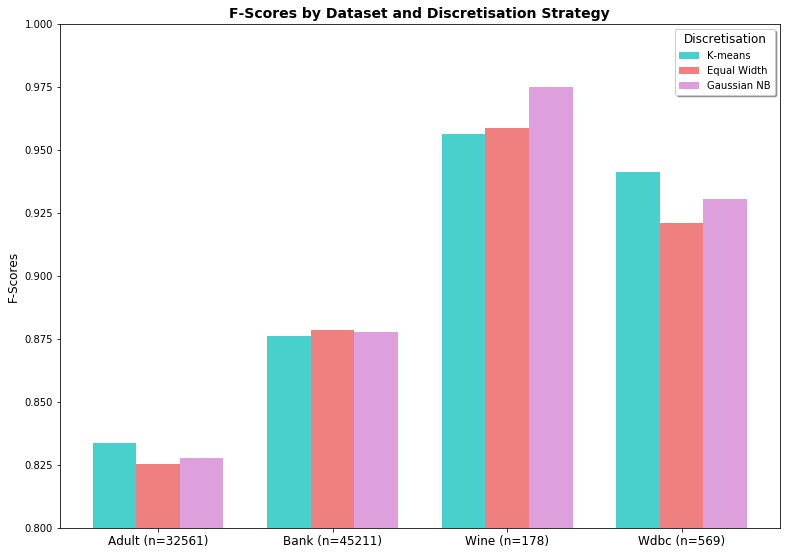

In [16]:
#Results
kmeans = np.array((adult_r_kmeans["f-score"], bank_r_kmeans["f-score"], wine_r_kmeans["f-score"], wdbc_r_kmeans["f-score"]))
eqw = np.array((adult_r_eqw["f-score"], bank_r_eqw["f-score"], wine_r_eqw["f-score"], wdbc_r_eqw["f-score"]))
gaus = np.array((adult_r["f-score"], bank_r["f-score"], wine_r["f-score"], wdbc_r["f-score"]))

plt.rcParams['figure.figsize'] = [10, 7]
X = np.arange(4)
ind = X + 0.25
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim(0.8,1)
ax.bar(X + 0.00, kmeans, color = 'mediumturquoise', width = 0.25)
ax.bar(X + 0.25, eqw, color = 'lightcoral', width = 0.25)
ax.bar(X + 0.50, gaus, color = 'plum', width = 0.25)

plt.ylabel('F-Scores',size=12)
plt.title('F-Scores by Dataset and Discretisation Strategy', weight='bold',size=14)
plt.xticks(ind, ('Adult (n=' + str(adult_cnfg["instances"])+')', 
                 'Bank (n=' + str(bank_cnfg["instances"])+')',
                 'Wine (n=' + str(wine_cnfg["instances"])+')',
                 'Wdbc (n=' + str(wdbc_cnfg["instances"])+')'), size=12)
plt.legend(('K-means', 'Equal Width', 'Gaussian NB'),shadow=True,title="Discretisation",title_fontsize=12)

plt.show()

### Q2
Implement a baseline model (e.g., random or 0R) and compare the performance of the na¨ıve Bayes classifier to this baseline on multiple datasets. Discuss why the baseline performance varies across datasets, and to what extent the na¨ıve Bayes classifier improves on the baseline performance.

In [17]:
def classify_zero_r(training_df, class_name, testing_df):
    """ Classifies according to the most common class in the training data.

        Args:
            training_class_obs: the observations of class in the training data
            num_to_classify: the number of instances to classify

        Returns:
            A pd.Series of class predictions with the same index as testing_df
    """
    training_class_obs = training_df[class_name]
    num_to_classify = len(testing_df)

    values, counts = np.unique(training_class_obs, return_counts=True)
    ind = np.argmax(counts)
    return pd.Series(
        np.full(num_to_classify, values[ind]),
        index=testing_df.index)


def classify_random(training_df, class_name, testing_df):
    """ Classifies data at random according to the relative frequencies of 
        each class in the training observations.

        Args:
            training_class_obs: the observations of class in the training data
            num_to_classify: the number of instances to classify

        Returns:
            A pd.Series of class predictions with the same index as testing_df
    """
    training_class_obs = training_df[class_name]
    num_to_classify = len(testing_df)

    class_vals = np.unique(training_class_obs)
    class_probs = discrete_probabilities(training_class_obs, class_vals)
    return pd.Series(
        np.random.choice(class_vals, size=num_to_classify, p=class_probs), 
        index=testing_df.index)

def classify_uniform(training_df, class_name, testing_df):
    """ Classifies data uniformly at random.

        Args:
            training_df: pd.DataFrame of training instances
            class_name: the name of the column of the class in training_df
            testing_df: a pd.DataFrame of test instances

        Returns:
            A pd.Series of class predictions with the same index as testing_df
    """
    class_vals = np.unique(training_df[class_name])
    return pd.Series(
        np.random.choice(class_vals, size=len(testing_df)), 
        index=testing_df.index)

def classify_one_r(training_df, class_name, testing_df):
    """ Classifies testing_df instances using a One-R classifier trained on 
        training_df

        Args:
            training_df: pd.DataFrame of training instances
            class_name: the name of the column of the class in training_df
            testing_df: a pd.DataFrame of test instances

        Returns:
            A pd.Series of class predictions with the same index as testing_df
    """

    #predict the most common class when an attribute is missing (Zero-R)
    values, counts = np.unique(training_df[class_name], return_counts=True)
    ind = np.argmax(counts)
    most_common_class = values[ind]

    #find the attribute which predicts class wih the lowest error rate
    min_error_rate = float("inf")
    best_attr = None
    best_predictor = None
    for attr in training_df.columns.drop(class_name):

        attr_groups = training_df[[attr, class_name]].groupby(attr).groups

        attr_predictor = {np.nan: most_common_class}
        for av, idx in attr_groups.items():
            
            #get most frequent class for av, choosing randomly if more than one
            most_frequent_class = training_df[class_name][idx].mode()
            choice = np.random.randint(len(most_frequent_class))

            attr_predictor[av] = most_frequent_class.iloc[choice]

        #check error rate of this attribute as predictor against training data
        attr_predictions = np.empty(len(training_df), dtype=training_df[class_name].dtype)
        for i, av in enumerate(training_df[attr]):
            attr_predictions[i] = attr_predictor[av]

        error_rate = np.count_nonzero(attr_predictions == training_df[class_name])

        if error_rate < min_error_rate:
            min_error_rate = error_rate
            best_attr = attr
            best_predictor = attr_predictor
    
    test_predictions = pd.Series(
        np.empty(len(testing_df), dtype=training_df[class_name].dtype), 
        index=testing_df.index)

    for i, row in testing_df.iterrows():
        test_predictions[i] = best_predictor[row[best_attr]]
    
    return test_predictions

def baseline_runner(df, cnfg, baseline, k=NUM_PARTITIONS):

    results = {"accuracy": 0, "precision": 0, "recall": 0, "f-score": 0}

    for train_set, test_set in cross_validation_splits(df, k):

        predictions = baseline(train_set, cnfg['class_col'], test_set)
        
        truth = test_set[cnfg['class_col']]
        a, p, r, f = evaluate(truth, predictions)

        results["accuracy"] += a
        results["precision"] += p
        results["recall"] += r
        results["f-score"] += f
    for key in results.keys():
        results[key] = results[key] / k
    return results

In [18]:
#NOTE: This cell will take a while to run.

# Normal Gaussian with new datasets
nurs_r = cross_validation_runner(nurs, nurs_cnfg, NUM_PARTITIONS)
mush_r = cross_validation_runner(mush, mush_cnfg, NUM_PARTITIONS)
lymph_r = cross_validation_runner(lymph, lymph_cnfg, NUM_PARTITIONS)

#Uniform
adult_uni = baseline_runner(adult, adult_cnfg, classify_uniform)
bank_uni = baseline_runner(bank, bank_cnfg, classify_uniform)
wine_uni = baseline_runner(wine, wine_cnfg, classify_uniform)
wdbc_uni = baseline_runner(wdbc, wdbc_cnfg, classify_uniform)
nurs_uni = baseline_runner(nurs, nurs_cnfg, classify_uniform)
mush_uni = baseline_runner(mush, mush_cnfg, classify_uniform)
lymph_uni = baseline_runner(lymph, lymph_cnfg, classify_uniform)

#zero_r
adult_0r = baseline_runner(adult, adult_cnfg, classify_zero_r)
bank_0r = baseline_runner(bank, bank_cnfg, classify_zero_r)
wine_0r = baseline_runner(wine, wine_cnfg, classify_zero_r)
wdbc_0r = baseline_runner(wdbc, wdbc_cnfg, classify_zero_r)
nurs_0r = baseline_runner(nurs, nurs_cnfg, classify_zero_r)
mush_0r = baseline_runner(mush, mush_cnfg, classify_zero_r)
lymph_0r = baseline_runner(lymph, lymph_cnfg, classify_zero_r)

#Random
adult_ran = baseline_runner(adult, adult_cnfg, classify_random)
bank_ran = baseline_runner(bank, bank_cnfg, classify_random)
wine_ran = baseline_runner(wine, wine_cnfg, classify_random)
wdbc_ran = baseline_runner(wdbc, wdbc_cnfg, classify_random)
nurs_ran = baseline_runner(nurs, nurs_cnfg, classify_random)
mush_ran = baseline_runner(mush, mush_cnfg, classify_random)
lymph_ran = baseline_runner(lymph, lymph_cnfg, classify_random)

#One-r
nurs_oner = baseline_runner(nurs, nurs_cnfg, classify_one_r)
mush_oner = baseline_runner(mush, mush_cnfg, classify_one_r)
lymph_oner = baseline_runner(lymph, lymph_cnfg, classify_one_r)

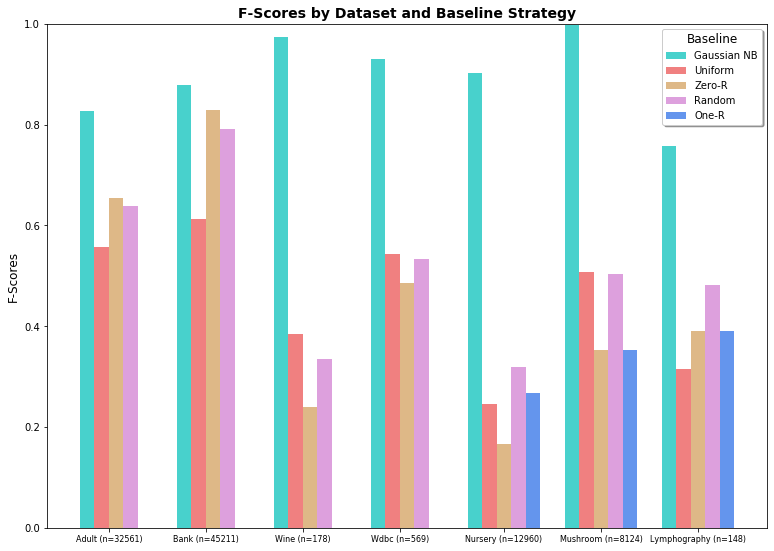

In [23]:
#Results

plt.rcParams['figure.figsize'] = [10, 7]
gaus = np.array((adult_r["f-score"], bank_r["f-score"], wine_r["f-score"], wdbc_r["f-score"],
                 nurs_r["f-score"], mush_r["f-score"],lymph_r["f-score"]))

uni = np.array((adult_uni["f-score"], bank_uni["f-score"], wine_uni["f-score"], wdbc_uni["f-score"],
                nurs_uni["f-score"], mush_uni["f-score"], lymph_uni["f-score"]))
zeror = np.array((adult_0r["f-score"], bank_0r["f-score"], wine_0r["f-score"], wdbc_0r["f-score"],
                  nurs_0r["f-score"], mush_0r["f-score"], lymph_0r["f-score"]))
random = np.array((adult_ran["f-score"], bank_ran["f-score"], wine_ran["f-score"], wdbc_ran["f-score"],
                   nurs_ran["f-score"], mush_ran["f-score"], lymph_ran["f-score"]))
oner = np.array((0, 0, 0, 0 ,nurs_oner["f-score"], mush_oner["f-score"], lymph_oner["f-score"]))

X = np.arange(7)
ind = X + 0.3
ind = [0.225, 1.225, 2.225, 3.225, 4.3, 5.3, 6.3]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim(0,1)
ax.bar(X + 0.00, gaus, color = 'mediumturquoise', width = 0.15)
ax.bar(X + 0.15, uni, color = 'lightcoral', width = 0.15)
ax.bar(X + 0.30, zeror, color = 'burlywood', width = 0.15)
ax.bar(X + 0.45, random, color = 'plum', width = 0.15)
ax.bar(X + 0.60, oner, color = 'cornflowerblue', width = 0.15)

plt.ylabel('F-Scores', size=12)
plt.title('F-Scores by Dataset and Baseline Strategy', weight='bold',size=14)
plt.xticks(ind, ('Adult (n=' + str(adult_cnfg["instances"])+')', 
                 'Bank (n=' + str(bank_cnfg["instances"])+')',
                 'Wine (n=' + str(wine_cnfg["instances"])+')',
                 'Wdbc (n=' + str(wdbc_cnfg["instances"])+')',
                 'Nursery (n=' + str(nurs_cnfg["instances"])+')',
                 'Mushroom (n=' + str(mush_cnfg["instances"])+')',
                 'Lymphography (n=' + str(lymph_cnfg["instances"])+')'), size=8)
plt.legend(('Gaussian NB', 'Uniform', 'Zero-R', 'Random', 'One-R'), shadow=True, title="Baseline",title_fontsize=12)

plt.show()


### Q5
Implement one of the advanced smoothing regimes (add-k, Good-Turing). Does changing the smoothing regime (or indeed, not smoothing at all) affect the effectiveness of the na¨ıve Bayes classifier? Explain why, or why not.

In [24]:
def laplace_smoothing(n_attr_obs, n_class_obs, n_attr_vals, alpha):
    """ When missing values arise, increases all counts by alpha (eg, missing values
        are now seen once. 1->2, 2->3 etc.

        Args:
            n_attr_obs: number of attribute observations
            n_class_obs: number of class observations
            n_attr_vals: number of attribute values
            alpha: laplace smoothing constant
            

        Returns:
            Smoothed probability for that attribute and class
    """
    return (n_attr_obs + alpha) / (n_class_obs + alpha * n_attr_vals)

def train_discrete_laplace(df, class_attr, class_vals, d_attr, alpha=1):
    """ For training Naive Bayes on a discrete attribute, with laplace smoothing

        For each class value computes the conditional probability of observing 
        each attribute value given that class value. 

        Args:
            df: a pd.DataFrame
            class_attr: the column in df of the class to predict
            class_vals: the possible values of class_attr
            d_attr: the column in df of the discrete attribute
            alpha: the alpha value in laplace smoothing

        Returns:
            A dictionary, keyed by class values, of dictonaries storing the 
            conditional probability of observing each attribute value
    """

    attr_vals = df[d_attr].unique()

    params = dict()
    for cv in class_vals:

        params[cv] = dict()
        cv_obs = df[df[class_attr] == cv]
        for av in attr_vals:
            num_av_obs = np.count_nonzero((cv_obs[d_attr] == av).to_numpy())
            params[cv][av] = laplace_smoothing(num_av_obs, cv_obs.shape[0], len(attr_vals), alpha)

    return params

In [25]:
#NOTE: This cell will take a while to run.

#All datasets should be loaded in previous questions
nurs_nosmooth = cross_validation_runner(nurs, nurs_cnfg, NUM_PARTITIONS)
mush_nosmooth = cross_validation_runner(mush, mush_cnfg, NUM_PARTITIONS)
lymph_nosmooth = cross_validation_runner(lymph, lymph_cnfg, NUM_PARTITIONS)
adult_nosmooth = cross_validation_runner(adult, adult_cnfg, NUM_PARTITIONS)
bank_nosmooth = cross_validation_runner(bank, bank_cnfg, NUM_PARTITIONS)


eps = 1e-10
eps_smoothing = lambda df, ca, cvs, da : train_discrete_standard(df, ca, cvs, da, eps=eps)

nurs_eps = cross_validation_runner(nurs, nurs_cnfg, NUM_PARTITIONS, eps_smoothing)
mush_eps = cross_validation_runner(mush, mush_cnfg, NUM_PARTITIONS, eps_smoothing)
lymph_eps = cross_validation_runner(lymph, lymph_cnfg, NUM_PARTITIONS, eps_smoothing)
adult_eps = cross_validation_runner(adult, adult_cnfg, NUM_PARTITIONS, eps_smoothing)
bank_eps = cross_validation_runner(bank, bank_cnfg, NUM_PARTITIONS, eps_smoothing)

#add-k smoothing a.k.a laplace smoothing (depending on k)
k = 1
add_k_smoothing = lambda df, ca, cvs, da : train_discrete_laplace(df, ca, cvs, da, alpha=k)

nurs_ak = cross_validation_runner(nurs, nurs_cnfg, NUM_PARTITIONS, add_k_smoothing)
mush_ak = cross_validation_runner(mush, mush_cnfg, NUM_PARTITIONS, add_k_smoothing)
lymph_ak = cross_validation_runner(lymph, lymph_cnfg, NUM_PARTITIONS, add_k_smoothing)
adult_ak = cross_validation_runner(adult, adult_cnfg, NUM_PARTITIONS, add_k_smoothing)
bank_ak = cross_validation_runner(bank, bank_cnfg, NUM_PARTITIONS, add_k_smoothing)


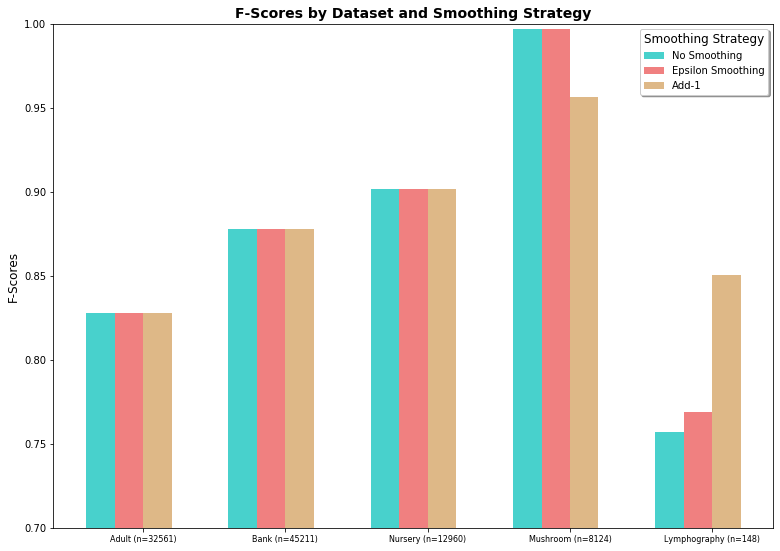

In [29]:
#plot the results
nosmooth = np.array((adult_nosmooth["f-score"], bank_nosmooth["f-score"],
                 nurs_nosmooth["f-score"], mush_nosmooth["f-score"],lymph_nosmooth["f-score"]))

eps_smooth = np.array((adult_eps["f-score"], bank_eps["f-score"],
                 nurs_eps["f-score"], mush_eps["f-score"], lymph_eps["f-score"]))

ak_smooth = np.array((adult_ak["f-score"], bank_ak["f-score"],
                 nurs_ak["f-score"], mush_ak["f-score"],lymph_ak["f-score"]))

X = np.arange(5)
ind = X + 0.3
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylim(0.7,1)
ax.bar(X + 0.00, nosmooth, color = 'mediumturquoise', width = 0.2)
ax.bar(X + 0.2, eps_smooth, color = 'lightcoral', width = 0.2)
ax.bar(X + 0.4, ak_smooth, color = 'burlywood', width = 0.2)

plt.ylabel('F-Scores', size=12)
plt.title('F-Scores by Dataset and Smoothing Strategy', weight='bold',size=14)
plt.xticks(ind, ('Adult (n=' + str(adult_cnfg["instances"])+')', 
                 'Bank (n=' + str(bank_cnfg["instances"])+')',
                 'Nursery (n=' + str(nurs_cnfg["instances"])+')',
                 'Mushroom (n=' + str(mush_cnfg["instances"])+')',
                 'Lymphography (n=' + str(lymph_cnfg["instances"])+')'), size=8)
plt.legend(('No Smoothing', 'Epsilon Smoothing', f'Add-{k}'), shadow=True, title="Smoothing Strategy",title_fontsize=12)

plt.show()
